In [32]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import os

In [33]:
!pip install opencv-python

In [34]:
import cv2

In [35]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [36]:
data1 = pd.read_csv('train.csv') 

In [37]:
ship = {0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}

In [38]:
data1['category'] = data1['category'] - 1
data1['label'] = data1['category'].map(ship)
data1['label']  = pd.Categorical(data1['label'])

In [39]:
data1.head(5) 

,image,category,label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


In [40]:
data1.shape 

(6252, 3)

In [41]:
data1['label'].value_counts() 

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: label, dtype: int64

In [42]:
path = 'images'
os.listdir(path)

['1001524.jpg',
 '1001804.jpg',
 '1003035.jpg',
 '1004028.jpg',
 '1004054.jpg',
 '1005343.jpg',
 '1007700.jpg',
 '1008439.jpg',
 '1010906.jpg',
 '1011369.jpg',
 '1011813.jpg',
 '1013663.jpg',
 '1014573.jpg',
 '1015027.jpg',
 '1016682.jpg',
 '1016683.jpg',
 '1019271.jpg',
 '1048999.jpg',
 '1049854.jpg',
 '1051155.jpg',
 '1056547.jpg',
 '1056555.jpg',
 '1059245.jpg',
 '1062001.jpg',
 '1062006.jpg',
 '1069397.jpg',
 '1072012.jpg',
 '1072257.jpg',
 '1072860.jpg',
 '1072861.jpg',
 '1073645.jpg',
 '1079150.jpg',
 '1084779.jpg',
 '1095624.jpg',
 '1097264.jpg',
 '1098729.jpg',
 '1098755.jpg',
 '1098763.jpg',
 '1098764.jpg',
 '1098766.jpg',
 '1101145.jpg',
 '1106366.jpg',
 '1112343.jpg',
 '1114370.jpg',
 '1114371.jpg',
 '1114372.jpg',
 '1114376.jpg',
 '1114377.jpg',
 '1114781.jpg',
 '1115492.jpg',
 '1119685.jpg',
 '1119689.jpg',
 '1120259.jpg',
 '1120419.jpg',
 '1121306.jpg',
 '1123736.jpg',
 '1124945.jpg',
 '1124946.jpg',
 '1124949.jpg',
 '1124951.jpg',
 '1124952.jpg',
 '1124953.jpg',
 '112500

In [43]:
img_list = list(data1['image'])

In [44]:
data_img = []

for each in img_list:
    each_path = os.path.join(path, each)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (126,126))
    data_img.append(each_img_resized)
X = np.array(data_img)

In [45]:
from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data1['category'].values.reshape(-1,1))

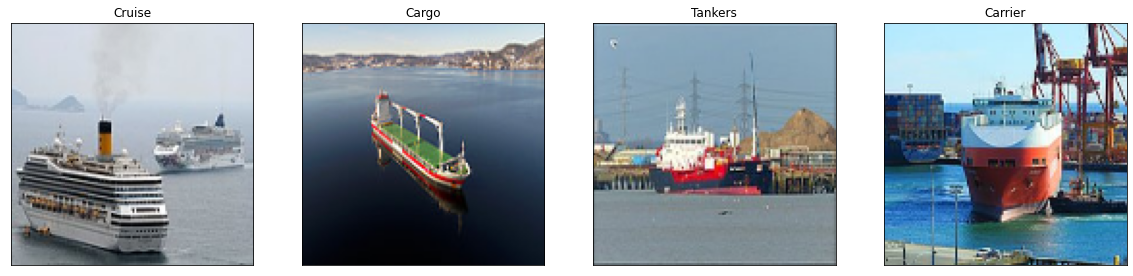

In [46]:
train_images = np.random.randint(0,6252,4) 
i = 1
plt.figure(figsize=(20,10))
for each in train_images:
    plt.subplot(1,4,i)
    i += 1
    plt.xticks([])
    plt.yticks([])
    plt.title(data1['label'].loc[each])
    plt.imshow(X[each])

In [47]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=45)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.15, random_state=45)

In [48]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

X_train:  (4516, 126, 126, 3)
y_train:  (4516, 5)


In [49]:
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)

X_val:  (798, 126, 126, 3)
y_val:  (798, 5)


In [50]:
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_test:  (938, 126, 126, 3)
y_test:  (938, 5)


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [52]:
train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 42,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
train_gen.fit(X_train)

In [53]:
validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 42,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
validation_gen.fit(X_val)

In [54]:
batch_size = 100
epochs = 20

In [55]:
base = Xception(include_top=False, weights='imagenet', input_shape=(126,126,3))
x = base.output
x = GlobalAveragePooling2D()(x)
head = Dense(5, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)

In [56]:
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

C:\Users\pkomp\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [57]:
model12 = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

C:\Users\pkomp\AppData\Local\Temp/ipykernel_12704/3584708835.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model12 = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/20
45/45 [==============================] - 367s 8s/step - loss: 1.3028 - accuracy: 0.4692 - val_loss: 1.8864 - val_accuracy: 0.4198
Epoch 2/20
45/45 [==============================] - 380s 8s/step - loss: 0.7465 - accuracy: 0.7115 - val_loss: 1.3887 - val_accuracy: 0.6090
Epoch 3/20
45/45 [==============================] - 355s 8s/step - loss: 0.5721 - accuracy: 0.7781 - val_loss: 0.7382 - val_accuracy: 0.7393
Epoch 4/20
45/45 [==============================] - 363s 8s/step - loss: 0.4892 - accuracy: 0.8059 - val_loss: 0.5531 - val_accuracy: 0.7982
Epoch 5/20
45/45 [==============================] - 377s 8s/step - loss: 0.4419 - accuracy: 0.8270 - val_loss: 0.5378 - val_accuracy: 0.7982
Epoch 6/20
45/45 [==============================] - 387s 9s/step - loss: 0.4078 - accuracy: 0.8447 - val_loss: 0.5268 - val_accuracy: 0.8145
Epoch 7/20
45/45 [==============================] - 367s 8s/step - loss: 0.3568 - accuracy: 0.8637 - val_loss: 0.5463 - val_accuracy: 0.8145
Epoch 8/20
45

In [58]:
test_img = pd.read_csv('test.csv')

In [59]:
test_img.head(5)

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [60]:
sample_img = test_img.sample(10)
img_list = list(sample_img['image'])

In [61]:
sample_img_data = []

for each in img_list:
    each_path = os.path.join(path, each)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (126,126))
    sample_img_data.append(each_img_resized)
sample_img_data = np.array(sample_img_data)

In [62]:
sample_pred = model.predict(sample_img_data)
sample_classes = np.argmax(sample_pred, axis = 1)

In [63]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_test_classes = np.argmax(y_test, axis = 1)

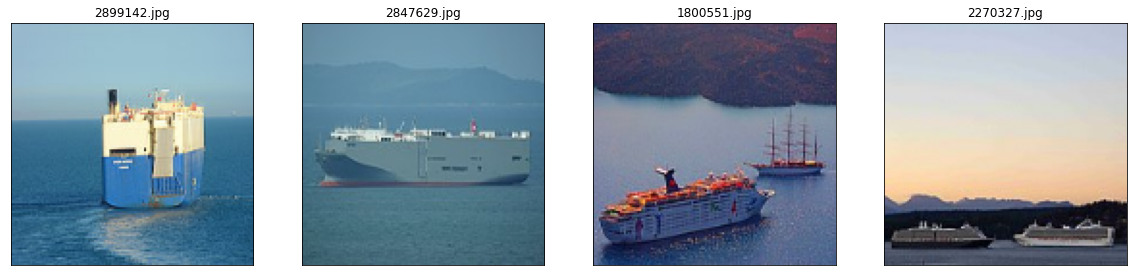

In [64]:
test_images = np.random.randint(0,6252,4) 
i = 1
plt.figure(figsize=(20,10))
for each in test_images:
    plt.subplot(1,4,i)
    i += 1
    plt.xticks([])
    plt.yticks([])
    plt.title(data1['image'].loc[each])
    plt.imshow(X[each])

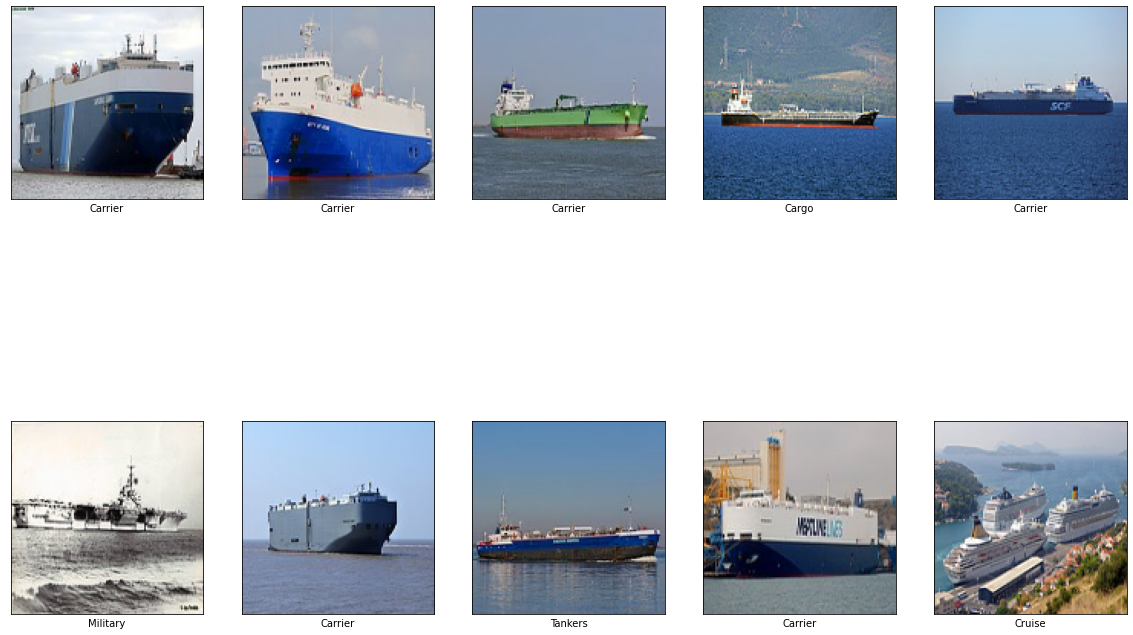

In [65]:
i = 0
plt.figure(figsize=(20,14))
for each in range(10):
    i += 1
    plt.subplot(2,5,i)
    plt.xlabel(str(ship[sample_classes[each]]))
    plt.imshow(sample_img_data[each])
    plt.xticks([])
    plt.yticks([])

In [66]:
from sklearn.metrics import classification_report

In [67]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       337
           1       0.99      0.83      0.91       172
           2       0.93      0.96      0.95       114
           3       0.95      0.98      0.97       129
           4       0.94      0.62      0.75       186

    accuracy                           0.88       938
   macro avg       0.92      0.87      0.89       938
weighted avg       0.89      0.88      0.87       938

